# BioPhysical parameters with Sentinel Toolbox Python bindings
## Disclaimer
** This notebook is a technology demonstration, none of the results are validated! **
This notebook shows how the 'snappy' Python module from the Sentinel toolbox. It can be tested inside the PROBA-V MEP notebook environment: https://proba-v-mep.esa.int/notebooks.
## Goal
The goal of this notebook is to compute BioPhysical parameters using Sentinel 2 reflectance data. The input reflectance data has already been radiometrically and geometrically corrected, and can be found on the exploitation platform.
This scenario is mainly used as a way to demonstrate how snappy can be used and configured inside a notebook, and how it integrates with Python libraries.
## Known Limitations
* Angle information is not taken into account when computing biophysical parameters. 
* When the snap process fails, it does not always provide clear error messages (I get a Java NullPointerException on some occasions, which is solved by running it again.)
* I was not yet able to properly configure logging of the snap toolbox from within a notebook.

## Table of contents
1. [Basic snappy configuration](#configuration)
2. [Load snappy](#p2)
3. [Find input data](#p3)
4. [Combine separate bands into a Sentinel 2 product](#p4)
5. [Create empty bands for angles](#p5)
6. [Resample bands to common resolution](#p6)
7. [Subset](#p7)
8. [Compute Biophysical parameters](#p8)
9. [Save result](#p9)
10. [Export to numpy, plot & Histogram](#p10)

## 1. Basic snappy configuration <a name="configuration"></a>
Before importing snappy, we write a config file into the working directory. Snappy will start a Java program in the background, and this config file allows us to modify some basic settings of this program, such as the amount of available memory.

In [1]:
snappy_ini = """
[DEFAULT]
snap_home = /usr/local/snap
# java_class_path: ./target/classes
# java_library_path: ./lib
# java_options: -Djava.awt.headless=false
java_max_mem: 512M
debug: True
"""
with open("snappy.ini", "w") as conf_file:
    conf_file.write(snappy_ini)

## 2. Load snappy  <a name="p2"></a>
We now import snappy and check some basic settings.
The userDir is important, as Snappy will use it to write various files. We check the location of this directory.

In [2]:
import sys
# import ESA SNAP (https://proba-v-mep.esa.int/esa-snappy-conflict)
sys.path.insert(0, '/opt/esa-snappy/py27')
import snappy

config = snappy.EngineConfig.instance()
print(config.userDir())
print(snappy.EngineConfig.instance().storagePath())

userdir = snappy.EngineConfig.instance().userDir()
userdir.toUri().toString()
from snappy import ProductUtils,ProductData

/opt/rh/python27/root/usr/lib64/python2.7/site-packages/snappy: java_module_dirs = 
['/usr/local/snap/probavbox/modules',
 '/usr/local/snap/rstb/modules',
 '/usr/local/snap/s1tbx/modules',
 '/usr/local/snap/s3tbx/modules',
 '/usr/local/snap/s2tbx/modules',
 '/usr/local/snap/snap/modules']
/opt/rh/python27/root/usr/lib64/python2.7/site-packages/snappy: env =
({'GeographicLib-Java.jar': '/usr/local/snap/snap/modules/ext/org.esa.snap.snap-core/net-sf-geographiclib/GeographicLib-Java.jar',
  'Jama.jar': '/usr/local/snap/snap/modules/ext/org.esa.snap.snap-core/Jama/Jama.jar',
  'LibSVM.jar': '/usr/local/snap/snap/modules/ext/org.esa.snap.snap-classification/nz-ac-waikato-cms-weka/LibSVM.jar',
  'abdera-client.jar': '/usr/local/snap/snap/modules/ext/org.esa.snap.snap-engine-utilities/org-apache-abdera/abdera-client.jar',
  'abdera-core.jar': '/usr/local/snap/snap/modules/ext/org.esa.snap.snap-engine-utilities/org-apache-abdera/abdera-core.jar',
  'abdera-i18n.jar': '/usr/local/snap/snap/modu

annotate_RasterDataNode_methods: Method "readPixels": modified parameter 4: mutable = True, return = True
annotate_RasterDataNode_methods: Method "readPixels": modified parameter 4: mutable = True, return = True
annotate_RasterDataNode_methods: Method "readPixels": modified parameter 4: mutable = True, return = True
annotate_RasterDataNode_methods: Method "readPixels": modified parameter 4: mutable = True, return = True
annotate_RasterDataNode_methods: Method "readPixels": modified parameter 4: mutable = True, return = True
annotate_RasterDataNode_methods: Method "readPixels": modified parameter 4: mutable = True, return = True
annotate_RasterDataNode_methods: Method "readPixels": modified parameter 4: mutable = True, return = True
annotate_RasterDataNode_methods: Method "readPixels": modified parameter 4: mutable = True, return = True
/home/driesj/.local/share/snap
/home/driesj/.local/share/snap/etc/snap.properties


### Load auxiliary data for Biophysical algorithm
The algorithm that we will use should normally write some data to the user dir. If this does not happen automatically, we can trigger it manually as shown below.

In [3]:
activator = snappy.jpy.get_type('org.esa.s2tbx.biophysical.BiophysicalActivator')
activator().start()

## 3. Find input data  <a name="p3"></a>
On the exploitation platform, a catalog client is available to find input data, we use this to find the filename of a radiometry product. More information on the catalog client API can be found here: http://mep-catalogclient.readthedocs.io/en/latest/.

In [4]:
from catalogclient import catalog
cat=catalog.Catalog()

In [5]:
import datetime
date = datetime.date(2017, 7, 18)
products = cat.get_products('CGS_S2_RADIOMETRY', 
                            fileformat='GEOTIFF', 
                            startdate=date, 
                            enddate=date)

In [6]:
p = products[0]
f = p.file('B02')
print(f)
path = f[5:]

file:/data/MTDA/CGS_S2/CGS_S2_RADIOMETRY/2017/07/18/S2B_20170718T101029Z_32TQQ_CGS_V102_000/S2B_20170718T101029Z_32TQQ_TOC_V102/S2B_20170718T101029Z_32TQQ_TOC-B02_10M_V102.tif


## 4. Combine separate bands into a Sentinel 2 product  <a name="p4"></a>
The algorithm that we want to use expects a product with specific metadata and bands. The products available on the platform are provided as individual tiff images. 
As a workaround, we load all images individually and combine them into a single product. I ensure that the layout of the product conforms to what the algorithm expects. Doing this required some trial and error, and inspection of the source code of the algorithm:
https://github.com/senbox-org/s2tbx/blob/6.x/s2tbx-biophysical/src/main/java/org/esa/s2tbx/biophysical/BiophysicalOp.java


In [7]:
S2BandConstant = snappy.jpy.get_type('org.esa.s2tbx.biophysical.BiophysicalOp$S2BandConstant')
def getProduct(filename, bandconstant):
    inputProduct = snappy.ProductIO.readProduct(filename.replace("B02", bandconstant.getFilenameBandId()))
    inputProduct.getBandAt(0).setSpectralWavelength(bandconstant.getWavelengthCentral())
    inputProduct.getBandAt(0).setName(bandconstant.getPhysicalName())
    return inputProduct

file20M = path.replace("10M","20M")

b3Product = getProduct(path, S2BandConstant.B3)
ProductUtils.copyBand(S2BandConstant.B4.getPhysicalName(),getProduct(path,S2BandConstant.B4),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B5.getPhysicalName(),getProduct(file20M,S2BandConstant.B5),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B6.getPhysicalName(),getProduct(file20M,S2BandConstant.B6),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B7.getPhysicalName(),getProduct(file20M,S2BandConstant.B7),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B8A.getPhysicalName(),getProduct(file20M,S2BandConstant.B8A),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B11.getPhysicalName(),getProduct(file20M,S2BandConstant.B11),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B12.getPhysicalName(),getProduct(file20M,S2BandConstant.B12),b3Product,True)
for name in b3Product.getBandNames():
    print(name)

B3
B4
B5
B6
B7
B8A
B11
B12


## 5. Create empty bands for angles  <a name="p5"></a>
The algorithm also expects angle information to be provided. At time of writing, there is no direct way to obtain this, so I add bands filled with zeroes.
Do note that the Sentinel 2 toolbox does support reading this informationn, so it should not be impossible to retrieve these bands as well.

In [8]:
L2BInput = snappy.jpy.get_type('org.esa.s2tbx.biophysical.BiophysicalOp$L2BInput')
S2LikeProduct = b3Product
S2LikeProduct.addBand(L2BInput.VIEW_ZENITH.getBandName(),"0.0", ProductData.TYPE_FLOAT32)
S2LikeProduct.addBand(L2BInput.SUN_ZENITH.getBandName(),"0.0", ProductData.TYPE_FLOAT32)
S2LikeProduct.addBand(L2BInput.SUN_AZIMUTH.getBandName(),"0.0", ProductData.TYPE_FLOAT32)
S2LikeProduct.addBand(L2BInput.VIEW_AZIMUTH.getBandName(),"0.0", ProductData.TYPE_FLOAT32)

org.esa.snap.core.datamodel.Band(objectRef=0x6ae0208)

## 6. Resample bands to common resolution  <a name="p6"></a>
The product we created contains both 10M and 20M bands. This is not supported by most other operators, so the first operation we apply is a resample operation.
Note that operations are evaluated lazily, so all operators in the next steps will not require a lot of time to create, and are only run when actual pixel values are retrieved.
Before we apply the actual operator, we show how operator information can be retrieved from the API.

In [9]:

gpf = snappy.GPF.getDefaultInstance()
ops = gpf.getOperatorSpiRegistry()
ops.loadOperatorSpis()

In [10]:
def get_snap_info(operator):
    """
    Returns information about SNAP operators and their parameters
    """
    op_spi = snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)
    print('Op name:', op_spi.getOperatorDescriptor().getName())
    print('Op alias:', op_spi.getOperatorDescriptor().getAlias()) 
    param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
    for param in param_Desc:
          print(param.getName(), "or", param.getAlias())

get_snap_info('BiophysicalOp')
get_snap_info('Subset')

('Op name:', 'org.esa.s2tbx.biophysical.BiophysicalOp')
('Op alias:', 'BiophysicalOp')
('computeLAI', 'or', None)
('computeFapar', 'or', None)
('computeFcover', 'or', None)
('computeCab', 'or', None)
('computeCw', 'or', None)
('Op name:', 'org.esa.snap.core.gpf.common.SubsetOp')
('Op alias:', 'Subset')
('bandNames', 'or', 'sourceBands')
('region', 'or', None)
('geoRegion', 'or', None)
('subSamplingX', 'or', None)
('subSamplingY', 'or', None)
('fullSwath', 'or', None)
('tiePointGridNames', 'or', None)
('copyMetadata', 'or', None)


In [11]:
get_snap_info('Resample')

('Op name:', 'org.esa.snap.core.gpf.common.resample.ResamplingOp')
('Op alias:', 'Resample')
('referenceBandName', 'or', 'referenceBand')
('targetWidth', 'or', 'targetWidth')
('targetHeight', 'or', 'targetHeight')
('targetResolution', 'or', 'targetResolution')
('upsamplingMethod', 'or', 'upsampling')
('downsamplingMethod', 'or', 'downsampling')
('flagDownsamplingMethod', 'or', 'flagDownsampling')
('resampleOnPyramidLevels', 'or', None)


In [12]:
parameters = snappy.HashMap()
parameters.put('referenceBandName', 'B3')
parameters.put('upsampling', 'Bilinear')
parameters.put('downsampling', 'Mean')
parameters.put('resampleOnPyramidLevels', False)
resampled = snappy.GPF.createProduct('Resample', parameters, S2LikeProduct)

## 7. Subset  <a name="p7"></a>
Let's make the image a bit smaller for faster processing.

In [13]:
parameters = snappy.HashMap()
parameters.put('region', '500,500,2000,2000')
subset = snappy.GPF.createProduct('Subset', parameters, resampled)

## 8. Compute Biophysical parameters  <a name="p8"></a>
The final operator to apply defines the actual parameters to compute. These parameters specify which output needs to be produced. All other inputs are contained in the S2 product.

In [14]:
parameters = snappy.HashMap()
parameters.put('computeCab', False)
parameters.put('computeCw', False)
parameters.put('computeFapar', True)
parameters.put('computeFcover', False)
parameters.put('computeLAI', False)
print(parameters)
biophysical_indexes = snappy.GPF.createProduct('BiophysicalOp', parameters, subset)

{computeCab=false, computeLAI=false, computeFcover=false, computeCw=false, computeFapar=true}


## 9. Save result  <a name="p9"></a>
At this point we can save the result to file. Rembember that the Sentinel toolbox computes results lazily. So this step will also compute all previous operations that have been applied.
Therefore, we time this step, to get an idea about the performance of our operator chain. (This includes reading the result, resampling, and saving back to disk.
The subsetting operation that we applied will specify how many pixels we actually process.

In [15]:
snappy.EngineConfig.instance().preferences().put("snap.dataio.bigtiff.compression.type","LZW")

In [16]:
%time snappy.ProductIO.writeProduct(biophysical_indexes,  "FAPARsnappy","GeoTIFF-BigTIFF")

CPU times: user 2min 13s, sys: 4.43 s, total: 2min 18s
Wall time: 40.4 s


## 10. Export to numpy, plot & Histogram  <a name="p9"></a>

In [17]:
import numpy
bioband = biophysical_indexes.getBandAt(0)
out = numpy.zeros(bioband.getRasterWidth()*bioband.getRasterHeight(), dtype=numpy.float32)
out = out.reshape((bioband.getRasterWidth(),bioband.getRasterHeight()))
out = bioband.readPixels(0,0,bioband.getRasterWidth(),bioband.getRasterHeight(),out)
print(out.shape)

(2000, 2000)


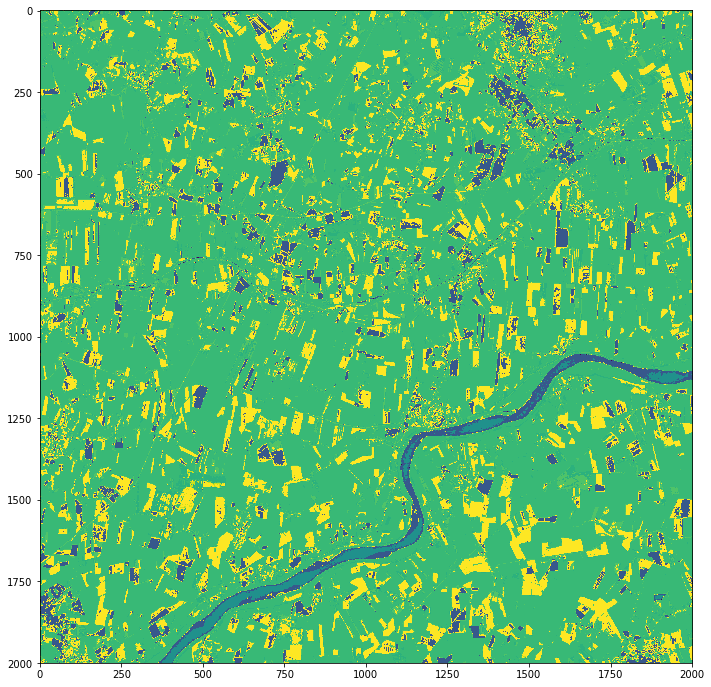

In [18]:
from rasterio import plot
import matplotlib
%matplotlib inline
from matplotlib import pyplot
fig, ax = pyplot.subplots(1, figsize=(12, 12))
plot.show(out,ax=ax)

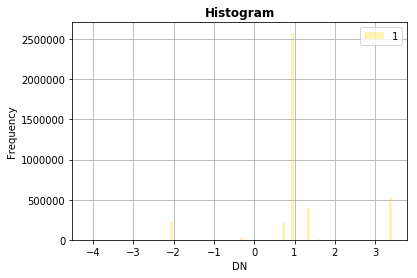

In [19]:
from rasterio.plot import show_hist
show_hist(out, bins=100, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")